In [20]:
!pip install pandas numpy matplotlib seaborn plotly yfinance
!pip install scikit-learn xgboost lightgbm catboost
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.8/381.8 kB 7.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      <string>:83: UserWarning: Cannot find ta-lib library, installation may fail.
      /tmp/pip-build-env-qm_jterd/overlay/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsWarning: `install_requires` overwritten in `pyproject.toml` (dependencies)
        corresp(dist, value, root_dir)
      running bdist_wheel
      running build
      running build_py
      creating build/lib.linux-x86_64-cpython-312/talib
      copying talib/abstract.py -> build/lib.linux-x86_64-cpython-312/talib
      copying talib/deprecated.py -> build/lib.li

In [22]:
conda install -c conda-forge ta-lib

/home/denys/miniconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
/home/denys/miniconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configurat

In [68]:
import yfinance as yf
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = yf.download("AAPL", start="2020-01-01", end="2023-01-01", auto_adjust=True)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]


[*********************100%***********************]  1 of 1 completed


In [69]:
close = df['Close'].values.ravel()


In [73]:
macd, macd_signal, macd_hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['MACD_signal'] = macd_signal


In [77]:
df['TEMA_30'] = talib.TEMA(close, timeperiod=30)


In [78]:
df['SMA_10'] = talib.SMA(close, timeperiod=10)


In [89]:
class MyStrategy:
    def __init__(self, data):
        self.data = data
        self.signals = pd.Series(index=data.index, dtype='int')

    def generate_signals(self):
        macd = self.data['MACD']
        signal = self.data['MACD_signal']
        close = self.data['Close']
        tema = self.data['TEMA_30']

        self.signals.iloc[0] = 0

        for i in range(1, len(self.data)):
            if np.isnan(macd.iloc[i-1]) or np.isnan(signal.iloc[i-1]) or np.isnan(tema.iloc[i]):
                self.signals.iloc[i] = 0
                continue

            def get_scalar(val):
                return val.item() if isinstance(val, pd.Series) else val

            macd_i = get_scalar(macd.iloc[i])
            macd_i_1 = get_scalar(macd.iloc[i-1])
            signal_i = get_scalar(signal.iloc[i])
            signal_i_1 = get_scalar(signal.iloc[i-1])
            close_i = get_scalar(close.iloc[i])
            tema_i = get_scalar(tema.iloc[i])

            if (macd_i > signal_i) and (macd_i_1 <= signal_i_1) and (close_i > tema_i):
                self.signals.iloc[i] = 1
            elif (macd_i < signal_i and macd_i_1 >= signal_i_1) or (close_i < tema_i):
                self.signals.iloc[i] = -1
            else:
                self.signals.iloc[i] = 0

        return self.signals


In [90]:
strategy = MyStrategy(df)
df['Signal'] = strategy.generate_signals()


In [92]:
# Backtesting
# Calculate the position: 1 if bought, 0 if sold or out of position
df['Position'] = 0
position = 0
for i in range(len(df)):
    if df['Signal'].iloc[i] == 1:
        position = 1
    elif df['Signal'].iloc[i] == -1:
        position = 0
    df.loc[df.index[i], 'Position'] = position

# Расчет доходности стратегии
df['Market_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Market_Return'] * df['Position'].shift(1)

# Кумулятивная доходность
df['Market_CumReturn'] = (1 + df['Market_Return']).cumprod() - 1
df['Strategy_CumReturn'] = (1 + df['Strategy_Return']).cumprod() - 1


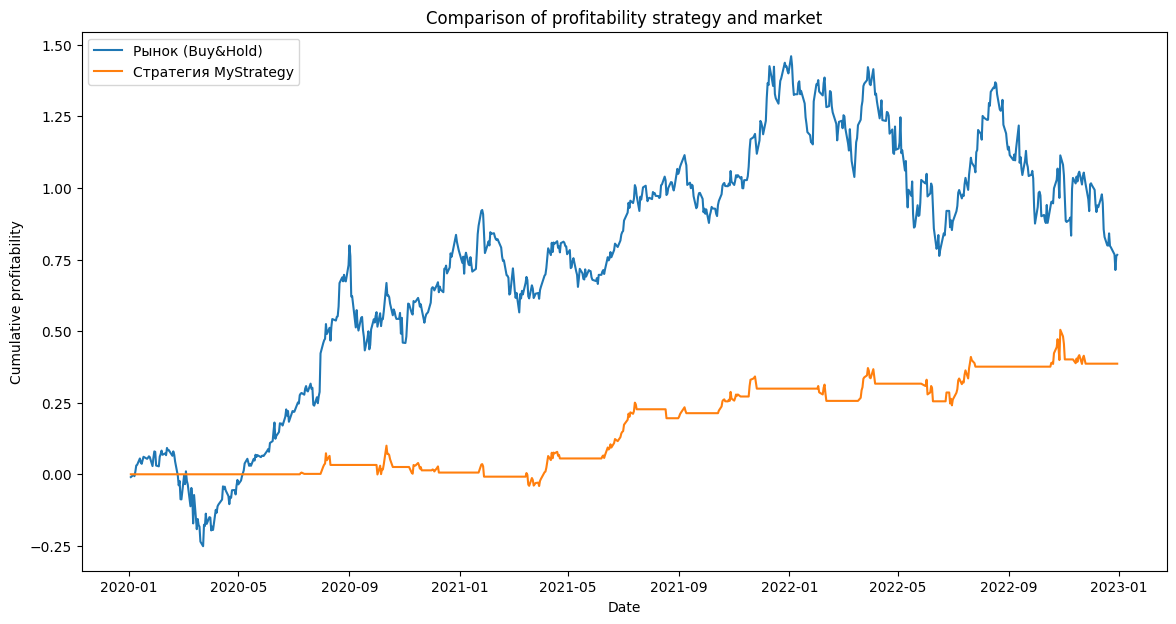

In [125]:
# Visualization of results
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Market_CumReturn'], label='Рынок (Buy&Hold)')
plt.plot(df.index, df['Strategy_CumReturn'], label='Стратегия MyStrategy')
plt.legend()
plt.title('Comparison of profitability strategy and market')
plt.xlabel('Date')
plt.ylabel('Cumulative profitability')
plt.show()


In [126]:
# Metric: Strategy and Market Performance
print(f"Total profitability strategy: {df['Strategy_CumReturn'].iloc[-1]*100:.2f}%")
print(f"Total Market Return: {df['Market_CumReturn'].iloc[-1]*100:.2f}%")


Total profitability strategy: 38.63%
Total Market Return: 76.63%


In [95]:
# SMA Crossover strategy
# Buy signal: when SMA_10 crosses SMA_50 from down to top
# Sell signal: when SMA_10 crosses SMA_50 from top to down


In [115]:
df.columns = ['_'.join(filter(None, col)) for col in df.columns]


In [116]:
df['SMA_10'] = df['Close_AAPL'].rolling(window=10).mean()
df['SMA_50'] = df['Close_AAPL'].rolling(window=50).mean()


In [118]:
class SmaCrossoverStrategy:
    def __init__(self, data):
        self.data = data
        self.signals = pd.Series(index=data.index, dtype='int')

    def generate_signals(self):
        sma_short = self.data['SMA_10']
        sma_long = self.data['SMA_50']

        for i in range(1, len(self.data)):
            if pd.isna(sma_short.iloc[i-1]) or pd.isna(sma_long.iloc[i-1]):
                self.signals.iloc[i] = 0
                continue

            prev_diff = sma_short.iloc[i-1] - sma_long.iloc[i-1]
            curr_diff = sma_short.iloc[i] - sma_long.iloc[i]

            if prev_diff <= 0 and curr_diff > 0:
                self.signals.iloc[i] = 1  # Buy
            elif prev_diff >= 0 and curr_diff < 0:
                self.signals.iloc[i] = -1  # Sell
            else:
                self.signals.iloc[i] = 0  # Hold

        return self.signals


In [120]:
# For MACD
df_macd = backtest_strategy(df, 'Signal')

# For SMA (we will create signals based on SMA: buy when the price is above SMA, sell when it is below)
df['SMA_Signal'] = 0
df.loc[df['Close_AAPL'] > df['SMA_10'], 'SMA_Signal'] = 1
df.loc[df['Close_AAPL'] < df['SMA_10'], 'SMA_Signal'] = -1

df_sma = backtest_strategy(df, 'SMA_Signal')


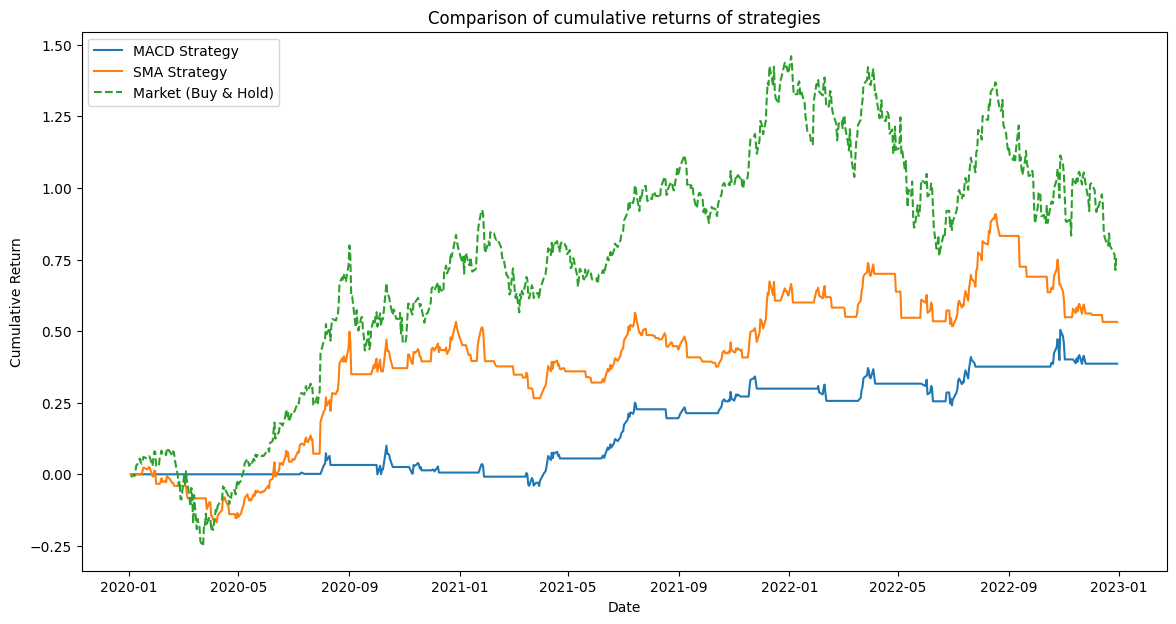

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(df_macd.index, df_macd['Strategy_CumReturn'], label='MACD Strategy')
plt.plot(df_sma.index, df_sma['Strategy_CumReturn'], label='SMA Strategy')
plt.plot(df_macd.index, df_macd['Market_CumReturn'], label='Market (Buy & Hold)', linestyle='--')
plt.legend()
plt.title('Comparison of cumulative returns of strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()


In [122]:
def calculate_performance_metrics(df, strategy_return_col='Strategy_Return'):    
    returns = df[strategy_return_col].dropna()

    # Cumulative Return (Final Value)
    cumulative_return = (1 + returns).prod() - 1

    # Average annual yield (CAGR)
    days = (df.index[-1] - df.index[0]).days
    cagr = (1 + cumulative_return) ** (365 / days) - 1

    # Volatility (standard deviation of returns * sqrt(252))
    volatility = returns.std() * np.sqrt(252)

    # Sharpe Ratio (risk-free rate is considered 0)
    sharpe_ratio = cagr / volatility if volatility != 0 else np.nan

    # Maximum Drawdown
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    return {
        'Cumulative Return': cumulative_return,
        'CAGR': cagr,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }


In [129]:
metrics_macd = calculate_performance_metrics(df_macd)
metrics_sma = calculate_performance_metrics(df_sma)

print("MACD Strategy Metrics:")
for k, v in metrics_macd.items():
    print(f"{k}: {v:.4f}")

print("\nSMA Strategy Metrics:")
for k, v in metrics_sma.items():
    print(f"{k}: {v:.4f}")


MACD Strategy Metrics:
Cumulative Return: 0.3863
CAGR: 0.1152
Volatility: 0.1396
Sharpe Ratio: 0.8254
Max Drawdown: -0.1281

SMA Strategy Metrics:
Cumulative Return: 0.5322
CAGR: 0.1532
Volatility: 0.2271
Sharpe Ratio: 0.6745
Max Drawdown: -0.1973
